In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from parameters import read_params

from scipy.special import gamma
def myGamma(zeta):
    return gamma(1-1/zeta)

DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"

def pv(name, mat):
    print("{}: {}".format(name.rjust(10), mat.shape))

In [2]:
param = read_params()

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866

 skill1880: (645, 2)
  wage1880: (645, 2)
       Q_A: (645, 5)
      Q_NA: (645, 5)
         Z: (5, 2)
        vA: (5, 1)
   Capital: (5, 1)
       phi: (4, 1)
       tau: (645, 645)
 amenities: (645, 5)


## Interest rate functions

In [3]:
def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

$$
r = R - \delta
$$

In [4]:
psi(param.r)

0.7655096595807223

In [5]:
myGamma(param.zeta)

2.3211529336709016

## Reshaping..

In [6]:
# now this is just for the short names
skills, wages = param.skill1880, param.wage1880
Q_A, Q_NA = param.Q_A, param.Q_NA

Z, vA, Capital, phi = param.Z, param.vA, param.Capital, param.phi

tau, amenities = param.tau, param.amenities

In [7]:
# TODO MAKE 4 DIMENSIONS (time, skill, sector, region)

skills = np.expand_dims(skills, 2).transpose((2,1,0))
pv("skills", skills)

wages = np.expand_dims(wages, 2).transpose((2,1,0))
pv("wages", wages)

Q = np.stack((Q_A, Q_NA), axis=1).transpose((2,1,0))
pv("Q", Q)

vA = vA.flatten()
vAt= np.array([vA[1], 1-vA[1]]).reshape(2,1)
pv("vAt", vAt)

Capital = Capital.flatten()
pv("Capital", Capital)

pv("tau", tau)

amenities = amenities.transpose((1,0))
pv("amenities", amenities)

    skills: (1, 2, 645)
     wages: (1, 2, 645)
         Q: (5, 2, 645)
       vAt: (2, 1)
   Capital: (5,)
       tau: (645, 645)
 amenities: (5, 645)


In [76]:
# define some constants for indexing
t = 0
A, NA = 0,1
L, H = 0,1
R,S,T = 2,1,0

# Remember that Psi is indexed like Psi[L,A]
Psi = np.array([[1,1],
                [param.q, param.mu * param.q]])

## Define methods

In [9]:
# useful for resets
def readWages():
    wages = param.wage1880
    wages = np.expand_dims(wages, 2).transpose((2,1,0))
    wages = wages / np.sum(wages) # what if we normalize for fun
    return wages

def readSkills():
    skills = param.skill1880
    skills = np.expand_dims(skills, 2).transpose((2,1,0))
    return skills

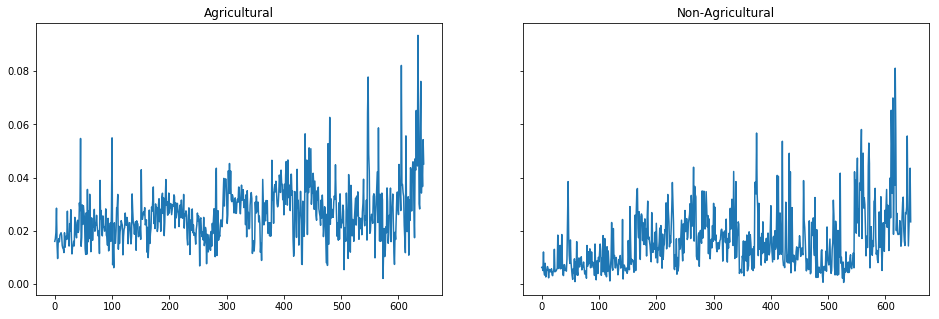

In [10]:
# useful for plotting
plot_params = {
    'alpha': 0.4,
    's': 4
}

def drawLog(wages):
    plt.scatter(np.log(wages[t,A]), np.log(wages[t,NA]),
           **plot_params)

def draw(wages):
    plt.scatter(wages[t,A], wages[t,NA],
           **plot_params)

def plotANA(x):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,5))
    
    ax1.plot(x[t,A])
    ax1.set_title("Agricultural")
    
    ax2.plot(x[t,NA])
    ax2.set_title("Non-Agricultural")
    
plotANA(wages)

## $\pi_{rst}$

In [11]:
def computePi(wages):
    """
    Parameters:
        wages - shape [time, Sectors, Regions]
        Q - shape [time, Sectors, Regions]
    
    Returns:
        pi has shape (1, 2, 645)
    """
    # Q is already raised**(sigma - 1)
    pi = Q[t] * wages**((1-param.alpha)*(1-param.sigma))
    
    # sum across regions
    normalize = np.sum(pi, axis=R)
    
    # normalize has shape (1,2), so we make it have shape (1,2,1)
    normalize = np.expand_dims(normalize, 2)
    pi = pi / normalize
    
    return pi

pi = computePi(wages)
np.sum(pi, axis=R)

array([[1., 1.]])

## $\Theta^h_{rt}$

In [12]:
def computeTheta(wages):
    """
    196 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs)
    """
    Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
    Theta_l = Theta[0,L]
    Theta_h = Theta[0,H]
    return Theta_h, Theta_l

def computeTheta2(wages):
    """
    304 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs,
    """
    z = param.zeta
    Theta_h = (Psi[H,A]*(wages[t,A]**z) + Psi[H,NA]*(wages[t,NA]**z))**(1/z)
    Theta_l = (Psi[L,A]*(wages[t,A]**z) + Psi[L,NA]*(wages[t,NA]**z))**(1/z)
    return Theta_h, Theta_l

a,b = computeTheta(wages)
c,d = computeTheta2(wages)

np.sum(a-c), np.sum(b-d) # these are the same

(0.0, 0.0)

# $\lambda$ and $L$

In [13]:
def computeLrt(skills):
    """
    Expects:
        skills[1,2,645]
        skills[0, L, :] == low-skilled populations across regions
    
    Returns:
        const_lambda - Lambda, 1-Lambda. This is constant throughout time
        totals - L. (portion of population in each region)
        skill_shares - share of high/low skill in each region. lambda_rt and 1-lambda_rt
        
    """
    const_lamda = np.sum(skills, axis=R)
    sums = np.sum(skills, axis=S)
    skill_shares = (skills/sums)
    return const_lamda, sums, skill_shares

def test_computeLrt(skills):
    const_lamda, sums, skill_shares = computeLrt(skills)

    print(const_lamda)
    print('L_rt sums to', np.sum(sums))
    
    x = np.sum(skill_shares, axis=S)
    print(np.allclose(x, np.ones_like(x)))
    
test_computeLrt(skills)

[[0.7046579  0.29534209]]
L_rt sums to 0.999999993419246
True


The majorit of commuting zones had agricultural employment shares exceeding 75% in 1880...

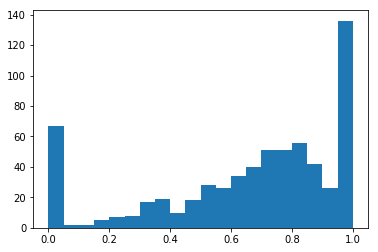

In [14]:
const_lamda, sums, skill_shares = computeLrt(skills)

plt.hist(skill_shares[t,A], bins=20)
plt.show()

In [15]:
np.sum(skills)

0.9999999934192461

## GDP

In [16]:
skills, wages = readSkills(), readWages()

def computeGDP(skills, wages):
    """
    GDP is an actual number!
    """
    Theta_h, Theta_l = computeTheta(wages)
    
    constant= 1/(1-param.alpha) * myGamma(param.zeta)
    GDP = constant * np.sum((skills[t,H] * Theta_h + skills[t,L] * Theta_l))
    
    return GDP

computeGDP(skills, wages)

0.0034030779422166675

## Sectoral prices (and normalizing wages)

In [17]:
param.Z

array([[0.045844, 0.051099],
       [0.067368, 0.084494],
       [0.098668, 0.15938 ],
       [0.083907, 0.27512 ],
       [0.11267 , 0.48463 ]])

In [18]:
R_t = 3.63

In [19]:
Zt = param.Z[t]
Zt.shape

sector = NA

temp = Q[t,sector,0] * ((1/Zt[sector] * (wages[t,sector,0] / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha))**(1-param.sigma)
temp

5.881977582807274

In [20]:
x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
x = x.transpose((1,0))
x.shape

x[sector, 0]

5.881977582807274

In [21]:
prices = np.sum(x, axis=1)**(1/(1-param.sigma))
prices # P_A, P_NA

array([0.02388413, 0.04312021])

In [22]:
# and then we normalize it
normprices = prices/prices[0]
normprices

array([1.        , 1.80539147])

What price normalization means for wages:
$$
P_{At} = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{w_{Ajt}}{1-\alpha}\big)^{1-\alpha} \cdot P_{At}^{-1} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

$$
1 = \Big(\sum_j \Big( stuff \cdot \big(\frac{ w_{Ajt} \cdot P_{At}^{-\frac{1}{1-\alpha}}}{1-\alpha}\big)^{1-\alpha} \Big)^{1-\sigma} \Big)^{\frac{1}{1-\sigma}}
$$

Or equivalently:
$$
w_{new} = \frac{ w_{old}}{ P_{At}^{\frac{1}{1-\alpha}}}
$$

In [23]:
normwages = wages/(prices[0]**(1/(1-param.alpha)))
normwages

array([[[0.0299579 , 0.03178196, 0.03611341, ..., 0.06841253,
         0.10130349, 0.08424844],
        [0.01173056, 0.01164318, 0.00952227, ..., 0.0524142 ,
         0.08129671, 0.04365236]]])

In [24]:
# just be careful: if we do it this way, the wages will be great!
np.sum(normwages, axis=R)

array([[31.83960945, 19.12317556]])

In [25]:
def priceNormalize(wages):
    """
    Sets the price of the agricultural good to 1
    
    Parameters:
        Q_rst
        Z_st
        param.alpha
        R_t
        
    Returns:
        normalized wages
    """
    Zt = param.Z[t]
    x = Q[t].transpose((1,0)) * (1/Zt * (wages[t].transpose((1,0)) / (1-param.alpha))**(1-param.alpha)* (R_t/param.alpha)**param.alpha)**(1-param.sigma)
    x = x.transpose((1,0))
    prices = np.sum(x, axis=1)**(1/(1-param.sigma))
    normprices = prices/prices[0]

    wages = wages/(prices[0]**(1/(1-param.alpha)))
    return wages

In [26]:
wages = readWages()

print(wages[t,NA,:5])

for i in range(10):
    wages = priceNormalize(wages)
    print(wages[t,NA,:5])

[0.00023018 0.00022846 0.00018685 0.00044211 0.00016725]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]
[0.01173056 0.01164318 0.00952227 0.02253097 0.00852342]


## Part 1: Testing the wage loop

In [27]:
vAt, vAt.shape

(array([[0.32289],
        [0.67711]]), (2, 1))

In [123]:
def logNorm(name, *args, precision=4):
    sums = [round(np.sum(a**2), precision) for a in args]
    print(name, sums)

logNorm("check", wages, skills)

check [0.001, 0.0992]


In [134]:
wages = readWages()

lr = 0.03

# these are fixed
const_lamda, sums, skill_shares = computeLrt(skills)

previous_newWages = wages
for i in range(300):
    # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

    wages = priceNormalize(wages)

    # compute the update
    pi = computePi(wages) # (1 by 2 by 645)
    Theta_h, Theta_l = computeTheta(wages) # (645,)
    GDP = computeGDP(skills, wages)
    revenue = (1-param.alpha) * pi * vAt * GDP
    GDP

    #  labor market clearing conditions

    # A
    s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
    s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
    x_A = myGamma(param.zeta) * (skills[t,H] * s_hA * Theta_h + skills[t,L] * s_lA * Theta_l)

    # NA
    s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
    s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
    x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA * Theta_h + skills[t,L] * s_lNA * Theta_l)
    
    newWages = revenue / np.vstack([x_A, x_NA])
    
    if i%2==0:
        print('-' * 10)
        logNorm("A:", s_lA + s_lNA)
        logNorm("x", x_A, x_NA)
        logNorm("revenue", revenue[t,A], revenue[t,NA])

    loss = np.sum((newWages - previous_newWages)**2)
    previous_newWages = newWages
    
    wages = lr * newWages + (1-lr) * wages

    if loss < 1e-7:
        print('w-- #{}: {}'.format(i, loss))
        break

    if i%2 == 0:
        pass
#         print(i, np.sum(newWages), np.sum(wages), loss)

----------
A: [645.0]
x [0.0038, 0.001]
revenue [0.0016, 0.0006]
----------
A: [645.0]
x [0.002, 0.0004]
revenue [0.0003, 0.0009]
----------
A: [645.0]
x [0.0002, 0.0086]
revenue [0.0001, 0.0045]
----------
A: [645.0]
x [0.0011, 0.0014]
revenue [0.0008, 0.0014]
----------
A: [645.0]
x [0.0014, 0.0055]
revenue [0.0003, 0.0041]
----------
A: [645.0]
x [0.0091, 0.0011]
revenue [0.0016, 0.0131]
----------
A: [645.0]
x [0.0223, 0.0475]
revenue [0.003, 0.0918]
----------
A: [645.0]
x [9.0604, 0.1593]
revenue [0.0501, 1.4571]
----------
A: [645.0]
x [2362.9111, 111.2802]
revenue [23.1682, 1246.0108]
----------
A: [645.0]
x [4702.9318, 52314.9887]
revenue [7519.2957, 48178.5528]
----------
A: [645.0]
x [747889004.7395, 2908551395.4173]
revenue [126993736.4139, 3008274464.6412]
----------
A: [645.0]
x [3.947738817341008e+16, 1856042366179099.0]
revenue [694204263880359.4, 1.387958917447464e+16]
----------
A: [645.0]
x [9.522858280419652e+25, 1.0196223906151456e+23]
revenue [1.6291023656630866e+

/home/cz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
/home/cz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/home/cz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
/home/cz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply
/home/cz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
/home/cz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A: [nan]
x [nan, nan]
revenue [nan, nan]
----------
A

In [29]:
def loopy(skills, wages, log=True):
    
    lr = 0.03

    # these are fixed
    const_lamda, sums, skill_shares = computeLrt(skills)

    previous_newWages = wages
    for i in range(300):
        # normalize wages BY THE PRICE OF THE AGRICULTURAL GOOD

        wages = priceNormalize(wages)

        # compute the update
        pi = computePi(wages) # (1 by 2 by 645)
        Theta_h, Theta_l = computeTheta(wages) # (645,)
        GDP = computeGDP(skills, wages)
        revenue = (1-param.alpha) * pi * vAt * GDP
        GDP

        #  labor market clearing conditions

        # A
        s_hA = Psi[H,A] * (wages[t,A] / Theta_h)**(param.zeta)
        s_lA = Psi[L,A] * (wages[t,A] / Theta_l)**(param.zeta)
        x_A = myGamma(param.zeta) * (skills[t,H] * s_hA + skills[t,L] * s_lA)

        # NA
        s_hNA = Psi[H,NA] * (wages[t,NA] / Theta_h)**(param.zeta)
        s_lNA = Psi[L,NA] * (wages[t,NA] / Theta_l)**(param.zeta)
        x_NA = myGamma(param.zeta) * (skills[t,H] * s_hNA + skills[t,L] * s_lNA)

        newWages = revenue / np.vstack([x_A, x_NA])

        loss = np.sum((newWages - previous_newWages)**2)
        previous_newWages = newWages

        wages = lr * newWages + (1-lr) * wages

        if loss < 1e-7:
            if log:
                print('w-- #{}: {}'.format(i, loss))
            break

        if i%20 == 0 and log:
            print('w-- #{}: {}'.format(i, loss))
            # print(i, np.sum(newWages), np.sum(wages), loss)
    
    return wages

In [30]:
wages = readWages()
newWages = loopy(skills, wages)

w-- #0: 113755.3757577779
w-- #20: 0.000231431817315696
w-- #40: 4.383103540591562e-05
w-- #60: 6.380734687294009e-06
w-- #77: 9.658384273052409e-08


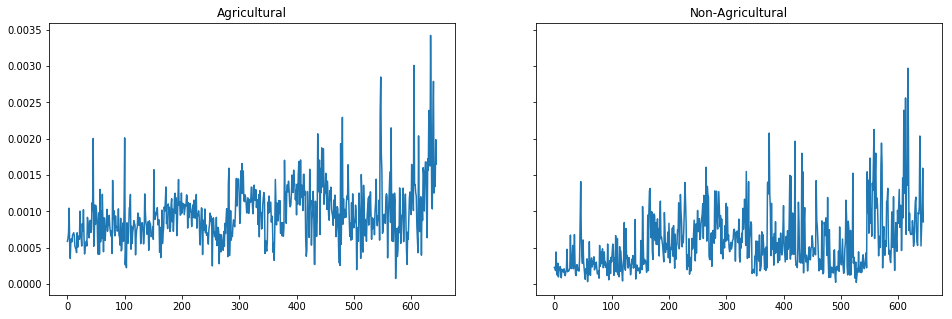

In [31]:
plotANA(wages) # before

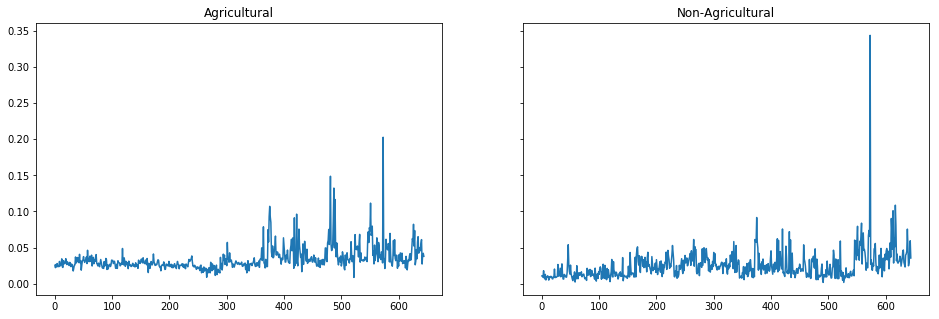

In [32]:
plotANA(newWages) # after

# Part 2: Space

## Moving probabilities

In [86]:
def computeMovingProbs(wages):
    
    theta_h, theta_l = computeTheta(wages)
    Theta = np.expand_dims(np.vstack([theta_l, theta_h]), 0)
    expectedUtility = myGamma(param.zeta)*Theta
    
    constant = myGamma(param.eta/param.zeta)/param.eta * psi(param.r)**(param.eta-1)
    
    # since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
    W_rt = constant * expectedUtility**param.eta + amenities[1] # amenities in 1910

    # tau is indexed like j x r
    stuff = np.expand_dims(W_rt, 2) - tau
    rho = np.exp(1/param.kappa * stuff)
    
    # and we normalize
    sums = np.sum(rho, axis=3) # across the R's, not the j's
    sums = np.expand_dims(sums, axis=3)

    movingProbs = rho/sums
    return movingProbs


def newLocations(skills, wages):
    """
    updates the new locations
    """
    movingProbs = computeMovingProbs(wages)
    oldL = np.expand_dims(skills, axis=3)
    new = np.sum(movingProbs * oldL, axis=2)
    
    return new

newSkills = newLocations(skills, wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

In [55]:
movingProbs = computeMovingProbs(newWages)
movingProbs.shape

(1, 2, 645, 645)

In [56]:
# since it's the people moving from region j --> r
# the probabilities of \sum_r \rho_{jr} = 1
np.sum(movingProbs, 3)

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

## Iteratively guessing better spatial allocations?

L---- #0: 0.0003881930111046257
L---- #10: 2.0337506747141924e-05
L---- #20: 1.5119327471475286e-05
L---- #30: 1.2814469016745834e-05
L---- #40: 1.0556394500155e-05
L---- #50: 8.51472270611943e-06
L---- #60: 6.78231093461445e-06
L---- #70: 5.358918673539747e-06
L---- #80: 4.209470536492506e-06
L---- #90: 3.291485716305517e-06
L---- #100: 2.564246218903178e-06
L---- #110: 1.9917383635953137e-06
L---- #120: 1.5433312609102502e-06
L---- #130: 1.1935865574029384e-06
L---- #137: 9.961758719699174e-07


Text(0,0.5,'log high-skill')

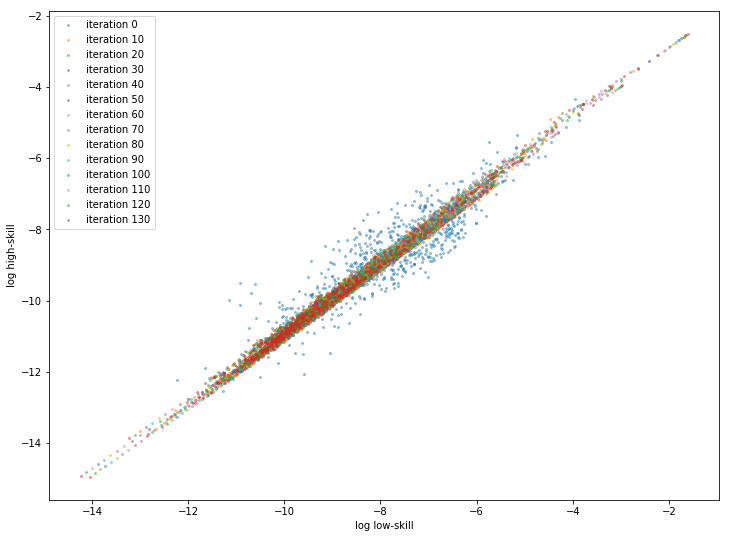

In [104]:
# init
wages  = readWages()
skills = readSkills()

plt.figure(figsize=(12,9))

lr = 0.94
losses = []
labels = []

# loop
for i in range(500):
    
    # find a fixed point wage, given location
    wages = loopy(skills, wages, log=False)
    
    # find the new locations, given the wage
    newSkills = newLocations(skills, wages)
    
    loss = np.sum((newSkills - skills)**2)
    losses.append(loss)
    
    skills = lr * newSkills + (1-lr)*skills
    
    if loss < 1e-6:
        print('L---- #{}: {}'.format(i, loss))
        break
    
    if i % 10 == 0:
        print('L---- #{}: {}'.format(i, loss))
        drawLog(skills)
        labels.append('iteration {}'.format(i))


plt.legend(labels)
plt.xlabel('log low-skill'); plt.ylabel('log high-skill')

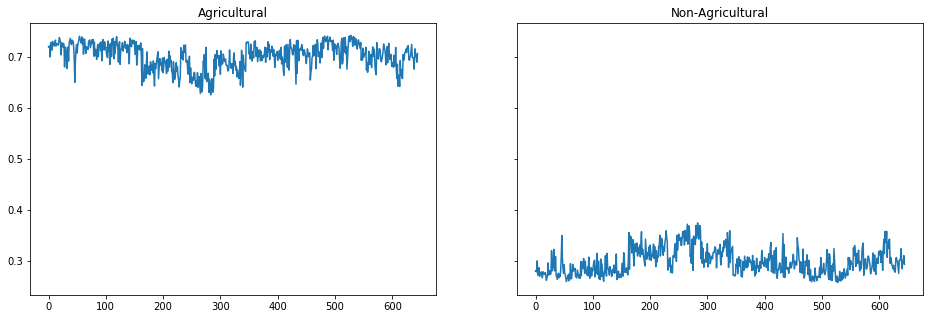

In [89]:
_, Lrt, _ = computeLrt(skills)
plotANA((skills/Lrt))

Text(0.5,0,'Regional Share of urban population')

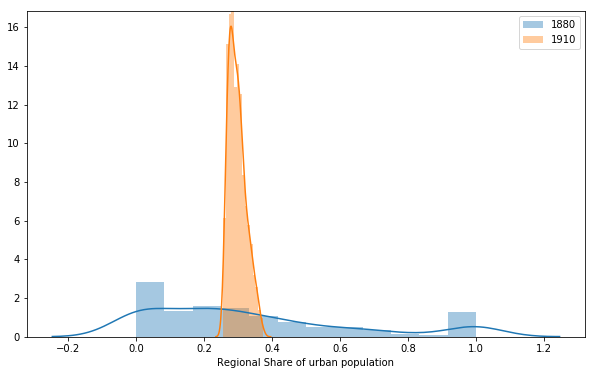

In [90]:
import seaborn as sns

# regional share of urban population in 1880
_, _, regionalShare1880 = computeLrt(readSkills())
_, _, regionalShare1910 = computeLrt(skills)

fig, axs = plt.subplots(ncols=1, figsize=(10,6))
sns.distplot(regionalShare1880[t,NA], ax=axs)
sns.distplot(regionalShare1910[t,NA], ax=axs)
axs.legend(['1880', '1910'])
axs.set_xlabel('Regional Share of urban population')

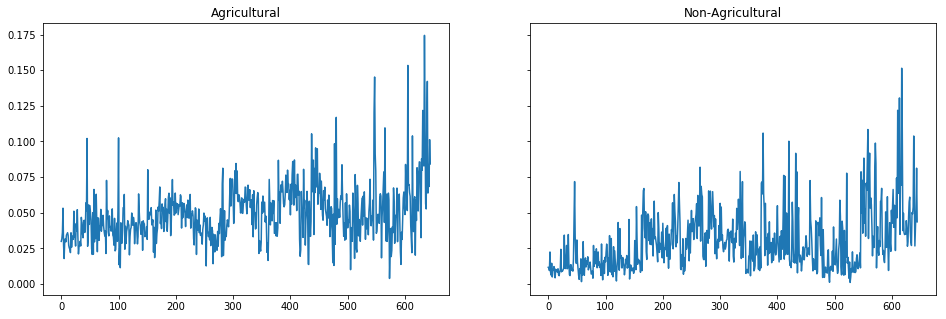

In [91]:
plotANA(priceNormalize(readWages())) # before

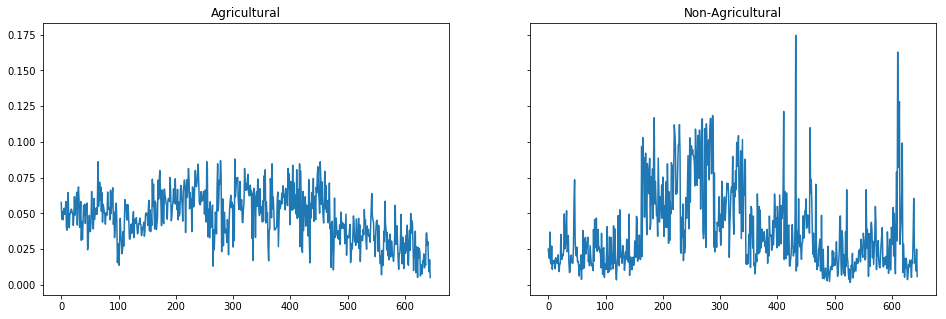

In [92]:
plotANA(wages) # after

In [105]:
# the wages don't change THAT much (1e-12)
newWages = loopy(skills, wages)

# plt.scatter(wages[t,A], np.log(np.abs(newWages - wages)[t,A]))
# plt.ylabel('Net change')

np.sum((newWages - wages)**2)

w-- #0: 0.4869551046772763
w-- #10: 8.011339900081314e-08


5.105602762121803e-06

In [94]:
# the distribution of people is close to the same too

newSkills = newLocations(skills, newWages)
np.sum((newSkills - skills)**2)

8.698339762918335e-10

So it definitely converged.

## Are these the 1910 wages and locations?

In [102]:
GDP_1910 = computeGDP(skills, wages)
K_1910 = (1-psi(param.r)) * (1-param.alpha) * GDP_1910
capitalRentalRate = GDP_1910/K_1910 * param.alpha 
capitalRentalRate - param.delta # should match param.r

-0.6935790530942079

In [103]:
param.r

2.8866

Text(0,0.5,'log manufacturing earnings 1910')

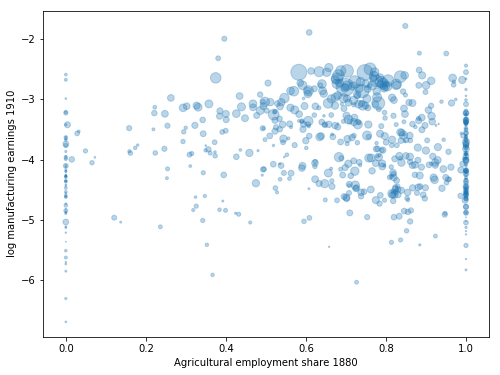

In [85]:
# Figure 3 in the paper
# agricultural employment share 1880 vs log Manufacturing earnings 1910

lamda, Lrt, lam_rt = computeLrt(oldSkills) # 1880
sizes = np.floor(Lrt[0]**0.6 * 2000)

plt.figure(figsize=(8,6))
plt.scatter(lam_rt[t,A], np.log(priceNormalize(wages)[t,NA]), alpha=0.3, s=sizes)
plt.xlabel('Agricultural employment share 1880')
plt.ylabel('log manufacturing earnings 1910')